## 1 导入工具包

In [1]:
# 导入transformers
import transformers
from transformers import AutoModel, AutoTokenizer,AutoConfig, AdamW, get_linear_schedule_with_warmup

# 导入torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


# 常用包
import re
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap


%matplotlib inline
%config InlineBackend.figure_format='retina' # 主题

In [2]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# 固定随机种子 以便复现模型
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
torch.cuda.is_available()

True

## 2 加载数据

In [4]:
sub = pd.read_csv("dataset/sub.csv")
train = pd.read_csv("dataset/train.csv")
test = pd.read_csv("dataset/test.csv")

In [5]:
train.head()

,id,level_1,level_2,level_3,level_4,content,label
0,0,工业/危化品类（现场）—2016版,（二）电气安全,6、移动用电产品、电动工具及照明,1、移动使用的用电产品和I类电动工具的绝缘线，必须采用三芯(单相)或四芯(三相)多股铜芯橡套软线。,"使用移动手动电动工具,外接线绝缘皮破损,应停止使用.",0
1,1,工业/危化品类（现场）—2016版,（一）消防检查,1、防火巡查,3、消防设施、器材和消防安全标志是否在位、完整；,一般,1
2,2,工业/危化品类（现场）—2016版,（一）消防检查,2、防火检查,6、重点工种人员以及其他员工消防知识的掌握情况；,消防知识要加强,0
3,3,工业/危化品类（现场）—2016版,（一）消防检查,1、防火巡查,3、消防设施、器材和消防安全标志是否在位、完整；,消防通道有货物摆放 清理不及时,0
4,4,工业/危化品类（现场）—2016版,（一）消防检查,1、防火巡查,4、常闭式防火门是否处于关闭状态，防火卷帘下是否堆放物品影响使用；,防火门打开状态,0


In [6]:
sub.head()

,id,label
0,0,1
1,1,0
2,2,1
3,3,1
4,4,1


### 2.1 查看缺失值

In [7]:
# 打印训练集和测试集中各属性的缺失值数量
def check_missing():
    print("train null nums")
    print(train.shape[0]-train.count())
    print("----这是分割线----")
    print("test null nums")
    print(test.shape[0]-test.count())

check_missing()

train null nums
id         0
level_1    0
level_2    0
level_3    0
level_4    0
content    2
label      0
dtype: int64
----这是分割线----
test null nums
id         0
level_1    0
level_2    0
level_3    0
level_4    0
content    4
dtype: int64


### 2.2 标签分布

In [8]:
# def check_labels():
#     print(train['label'].value_counts())
#     sns.countplot(train.label)
#     plt.xlabel('label count')

# check_labels()


## 3 数据预处理

In [9]:
# 缺失值用“空值”填充
train['content'] = train['content'].fillna('空值')
test['content'] = test['content'].fillna('空值')

In [10]:
# 去除训练集多余字符
train['level_1']=train['level_1'].apply(lambda x:x.split('（')[0])
train['level_2']=train['level_2'].apply(lambda x:x.split('）')[-1])
train['level_3']=train['level_3'].apply(lambda x:re.split(r'[0-9]、',x)[-1])
train['level_4']=train['level_4'].apply(lambda x:re.split(r'[0-9]、',x)[-1])

# 去除测试集多余字符
test['level_1']=test['level_1'].apply(lambda x:x.split('（')[0])
test['level_2']=test['level_2'].apply(lambda x:x.split('）')[-1])
test['level_3']=test['level_3'].apply(lambda x:re.split(r'[0-9]、',x)[-1])
test['level_4']=test['level_4'].apply(lambda x:re.split(r'[0-9]、',x)[-1])

In [11]:
train.head()

,id,level_1,level_2,level_3,level_4,content,label
0,0,工业/危化品类,电气安全,移动用电产品、电动工具及照明,移动使用的用电产品和I类电动工具的绝缘线，必须采用三芯(单相)或四芯(三相)多股铜芯橡套软线。,"使用移动手动电动工具,外接线绝缘皮破损,应停止使用.",0
1,1,工业/危化品类,消防检查,防火巡查,消防设施、器材和消防安全标志是否在位、完整；,一般,1
2,2,工业/危化品类,消防检查,防火检查,重点工种人员以及其他员工消防知识的掌握情况；,消防知识要加强,0
3,3,工业/危化品类,消防检查,防火巡查,消防设施、器材和消防安全标志是否在位、完整；,消防通道有货物摆放 清理不及时,0
4,4,工业/危化品类,消防检查,防火巡查,常闭式防火门是否处于关闭状态，防火卷帘下是否堆放物品影响使用；,防火门打开状态,0


In [12]:
train['text'] = train['content'] + '[SEP]' + train['level_1'] + '[SEP]' + train['level_2'] + '[SEP]' + train['level_3'] + '[SEP]' + train['level_4']
test['text'] = test['content'] + '[SEP]' + test['level_1'] + '[SEP]' + test['level_2'] + '[SEP]' + test['level_3'] + '[SEP]' + test['level_4']

In [13]:
train.head()

,id,level_1,level_2,level_3,level_4,content,label,text
0,0,工业/危化品类,电气安全,移动用电产品、电动工具及照明,移动使用的用电产品和I类电动工具的绝缘线，必须采用三芯(单相)或四芯(三相)多股铜芯橡套软线。,"使用移动手动电动工具,外接线绝缘皮破损,应停止使用.",0,"使用移动手动电动工具,外接线绝缘皮破损,应停止使用.[SEP]工业/危化品类[SEP]电气安..."
1,1,工业/危化品类,消防检查,防火巡查,消防设施、器材和消防安全标志是否在位、完整；,一般,1,一般[SEP]工业/危化品类[SEP]消防检查[SEP]防火巡查[SEP]消防设施、器材和消...
2,2,工业/危化品类,消防检查,防火检查,重点工种人员以及其他员工消防知识的掌握情况；,消防知识要加强,0,消防知识要加强[SEP]工业/危化品类[SEP]消防检查[SEP]防火检查[SEP]重点工种...
3,3,工业/危化品类,消防检查,防火巡查,消防设施、器材和消防安全标志是否在位、完整；,消防通道有货物摆放 清理不及时,0,消防通道有货物摆放 清理不及时[SEP]工业/危化品类[SEP]消防检查[SEP]防火巡查[...
4,4,工业/危化品类,消防检查,防火巡查,常闭式防火门是否处于关闭状态，防火卷帘下是否堆放物品影响使用；,防火门打开状态,0,防火门打开状态[SEP]工业/危化品类[SEP]消防检查[SEP]防火巡查[SEP]常闭式防...


In [14]:
# 新增text_len列
train['text_len'] = train['text'].map(len)
test['text_len'] = test['text'].map(len)

# 查看文本长度分布
def check_text_length():
    print(train['text'].map(len).describe())
    print('------------------------')
    print(test['text'].map(len).describe())

check_text_length()

count    12000.000000
mean        80.439833
std         21.913662
min         43.000000
25%         66.000000
50%         75.000000
75%         92.000000
max        298.000000
Name: text, dtype: float64
------------------------
count    18000.000000
mean        80.762611
std         22.719823
min         43.000000
25%         66.000000
50%         76.000000
75%         92.000000
max        520.000000
Name: text, dtype: float64


In [15]:
sum(train['text_len']>200) # text文本长度大于200的个数

11

In [16]:
sum(test['text_len']>200) # text文本长度大于200的个数

23

## 4 Tokenizer

In [17]:
PRE_TRAINED_MODEL_NAME = 'bert-base-chinese'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

### 选取文本最大长度

In [18]:
# 查看句子分词后，input_ids的长度是多少
token_lens = []

for txt in train.text:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

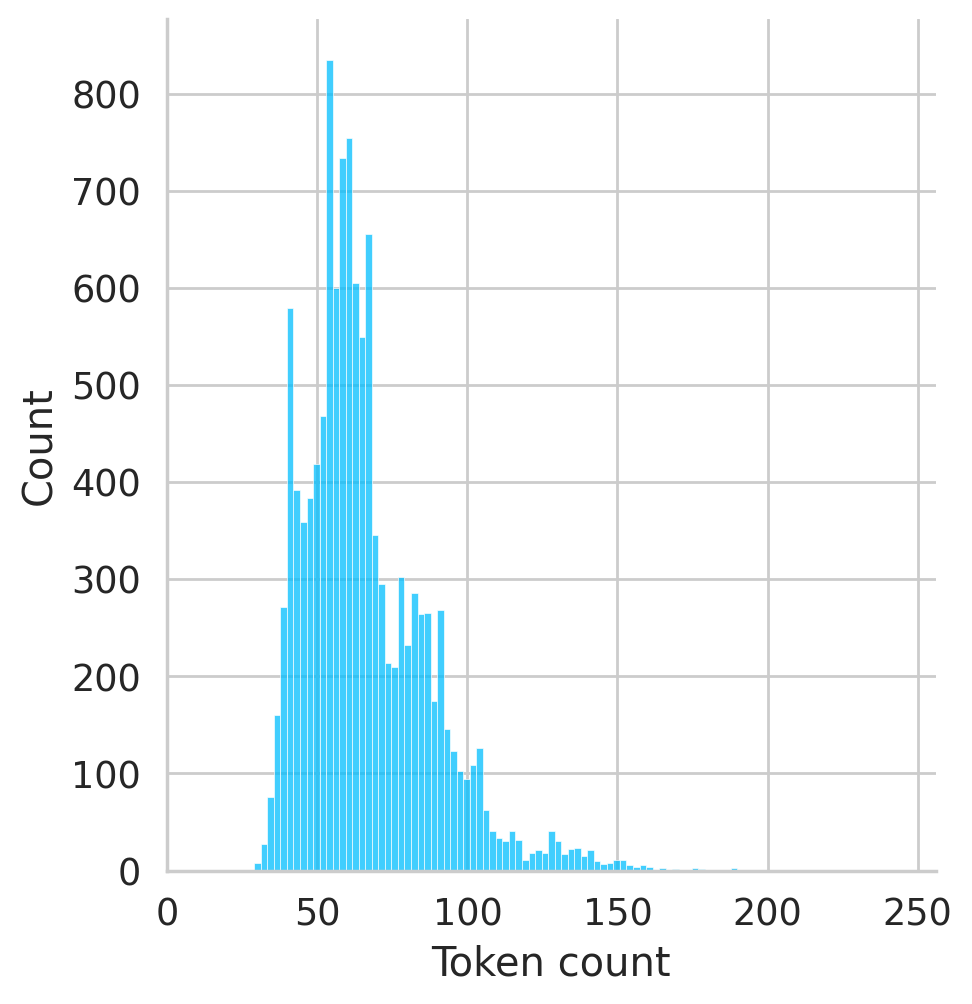

In [19]:
sns.displot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [20]:
# 从上图看出 可设置最大长度为160
MAX_LEN = 160

## 5 构建数据集

In [21]:
class EnterpriseDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        """
        Args:
            texts (一维ndarray): 数据集每行的text组成的数组
            labels (一维ndarray): 数据集每行的label组成的数组
            tokenizer (_type_): 模型的tokenizer
            max_len (int): 最大分词长度为160
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        """
            迭代取第index条数据
        """
        text = str(self.texts[index])
        label = self.labels[index]

        encoding=self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'texts':text,
            'input_ids':encoding['input_ids'].flatten(),
            'attention_mask':encoding['attention_mask'].flatten(),
            # token_type_ids:0  # 输入就一个句子，无需分不同id
            'labels':torch.tensor(label,dtype=torch.long)
        }

In [22]:
df_train, df_test = train_test_split(train, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_train.shape, df_val.shape, df_test.shape

((10800, 9), (600, 9), (600, 9))

In [23]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    """
        将数据集封装成dataloader
    """
    ds = EnterpriseDataset(
        texts=df['text'].values,
        labels=df['label'].values,
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )

    return DataLoader(
        ds,
        batch_size=batch_size
    )

In [24]:
BATCH_SIZE = 4

# dataloader中每次返回BATCH_SIZE个EnterpriseDataset对象，包含这个批次的texts,input_ids,attention_mask和labels信息
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

## 6 基于Huggingface 的企业隐患识别模型构建

In [25]:
bert_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
class EnterpriseDangerClassifier(nn.Module):
    def __init__(self, class_num):
        super().__init__()
        self.bert = bert_model
        self.drop = nn.Dropout(p=0.3)
        self.linear = nn.Linear(self.bert.config.hidden_size, 2)  # BERT的hidden_size是768，什么东西？
    
    def forward(self, input_ids, attention_mask):
        # last_hidden_state：最后一个隐藏层的序列的输出，大小是(batch_size, sequence_length, hidden_size)
        # pooled_output：[CLS]token的输出，大小是(batch_size, hidden_size)
        last_hidden_state, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict = False
        )
        output = self.drop(pooled_output)
        output = self.linear(output)
        return output

In [27]:
class_names = [0, 1]
model = EnterpriseDangerClassifier(len(class_names))
model = model.to(device)

## 7 模型训练

In [28]:
EPOCHS = 10 # 训练轮数

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/home/yunchang/anaconda3/envs/pytorch/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [29]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, total_num):
    model = model.train() # train模式
    losses = []
    correct_predictions = 0
    for d in data_loader:  # d是一个批次的数据，包括texts,input_ids,attention_mask,labels,都是[4,n]维度
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["labels"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / total_num, np.mean(losses)

In [30]:
def eval_model(model, data_loader, loss_fn, device, total_num):
    model = model.eval() # 评估模式
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:  # d是一个批次的数据，包括texts,input_ids,attention_mask,labels,都是[4,n]维度
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, preds)

            losses.append(loss.item())
            correct_predictions += torch.sum(preds == targets)
    
    return correct_predictions.double() / total_num, np.mean(losses) 

In [31]:
history = defaultdict(list) # 记录10轮loss和acc
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 20)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Epoch 1/10
--------------------


/home/yunchang/anaconda3/envs/pytorch/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 0.5018044404938161 accuracy 0.8899999999999999
Val   loss 0.015065693488965432 accuracy 0.9

Epoch 2/10
--------------------
Train loss 0.5003880746838533 accuracy 0.8905555555555555
Val   loss 0.015796173363924026 accuracy 0.9

Epoch 3/10
--------------------
Train loss 0.5010841889339671 accuracy 0.8905555555555555
Val   loss 0.016498683020472527 accuracy 0.9

Epoch 4/10
--------------------
Train loss 0.4977451379623057 accuracy 0.8905555555555555
Val   loss 0.017363067381083966 accuracy 0.9

Epoch 5/10
--------------------
Train loss 0.4937625512254804 accuracy 0.8905555555555555
Val   loss 0.016822028905153275 accuracy 0.9

Epoch 6/10
--------------------
Train loss 0.49127447464693064 accuracy 0.8905555555555555
Val   loss 0.01894194446504116 accuracy 0.9

Epoch 7/10
--------------------
Train loss 0.4837182287811474 accuracy 0.8905555555555555
Val   loss 0.01716584766904513 accuracy 0.9

Epoch 8/10
--------------------
Train loss 0.4838732646667847 accuracy 0.89055555

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

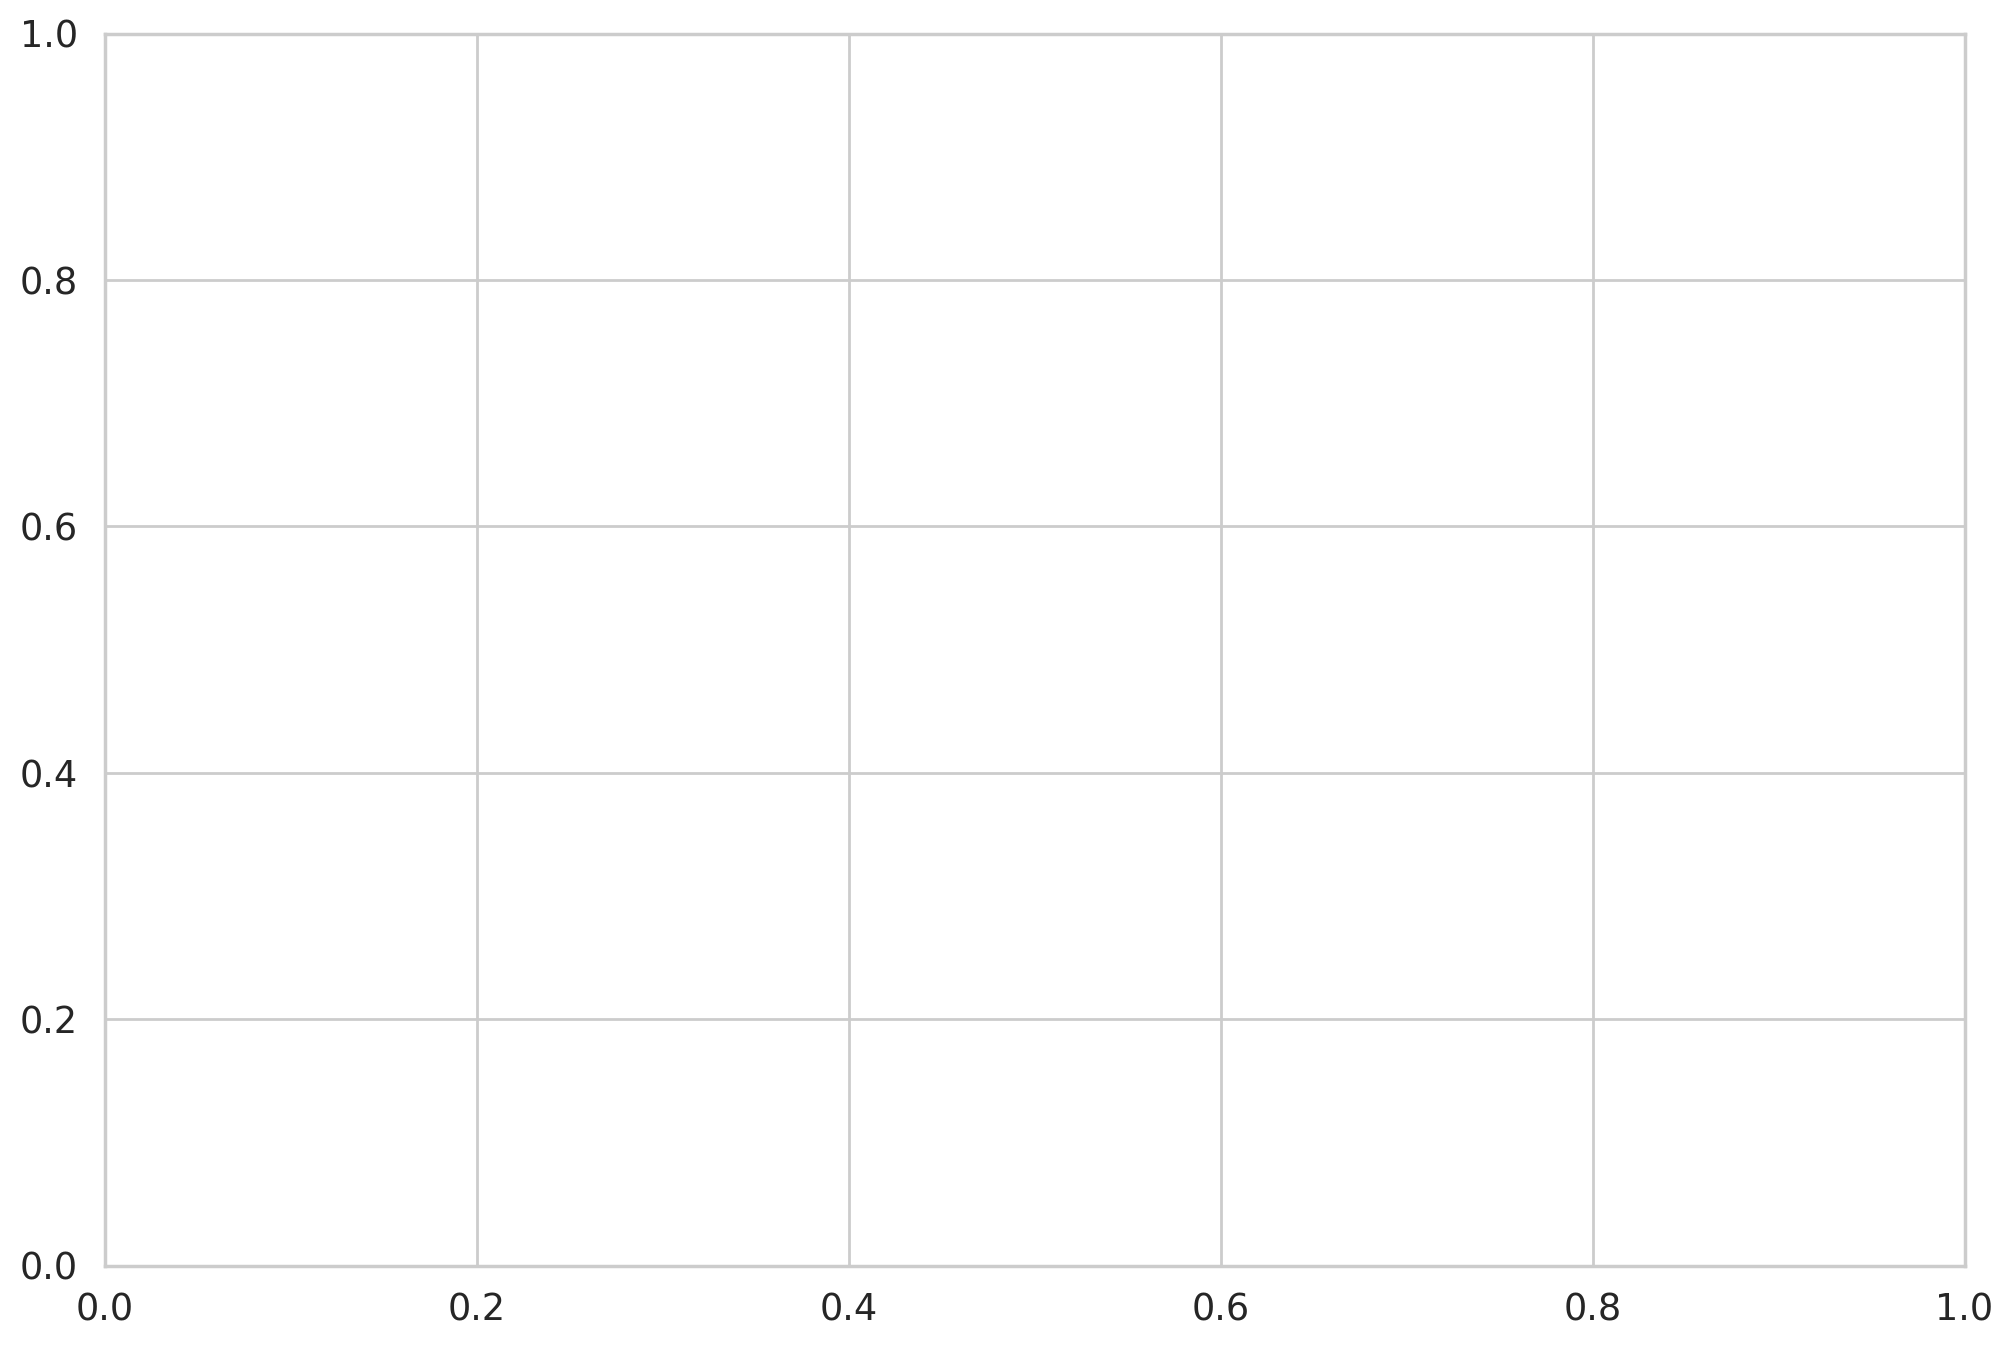

In [47]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## 8 模型评估

In [50]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/home/yunchang/anaconda3/envs/pytorch/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


0.9233333333333333

In [53]:
def get_predictions(model, data_loader):
    model = model.eval()

    predictions = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1) # 类别

            predictions.extend(preds)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    
    return predictions, real_values

In [54]:
y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

print(classification_report(y_test, y_pred, target_names=[str(label) for label in class_names])) # 分类报告

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       554
           1       0.00      0.00      0.00        46

    accuracy                           0.92       600
   macro avg       0.46      0.50      0.48       600
weighted avg       0.85      0.92      0.89       600



/home/yunchang/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yunchang/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yunchang/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,